![title](data/customer_support_flow.png)

# Notebook Config

In [1]:
!pip install --quiet -U langchain langchain_community langchain-ollama sentence-transformers faiss-cpu

In [10]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# embedding model for creating the vector store
embed_model = SentenceTransformer('all-mpnet-base-v2')

# chat llm for text generation
llm = ChatOllama(model="llama3.2", temperature=0)

# Data

In [3]:
cust_support_qa_data = pd.read_csv("hf://datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

print(cust_support_qa_data.shape)
cust_support_qa_data.head()

(26872, 5)


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [4]:
cust_support_qa_data['intent'].value_counts()

intent
edit_account                1000
switch_account              1000
check_invoice               1000
complaint                   1000
contact_customer_service    1000
delivery_period              999
registration_problems        999
check_payment_methods        999
contact_human_agent          999
payment_issue                999
newsletter_subscription      999
get_invoice                  999
place_order                  998
cancel_order                 998
track_refund                 998
change_order                 997
get_refund                   997
create_account               997
check_refund_policy          997
review                       997
set_up_shipping_address      997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: count, dtype: int64

In [5]:
# filter few intents to limit rows for faster execution

cust_support_qa_data = cust_support_qa_data[cust_support_qa_data['intent'].isin(
    ['track_order', 'cancel_order', 'get_refund', 'delivery_period']
)].reset_index().rename(columns = {"index" : "row_num"})

print(cust_support_qa_data.shape)

(3989, 6)


In [6]:
cust_support_qa_data['len_instruction'] = cust_support_qa_data['instruction'].str.split(" ").apply(len)
cust_support_qa_data['len_response'] = cust_support_qa_data['response'].str.split(" ").apply(len)

<Axes: >

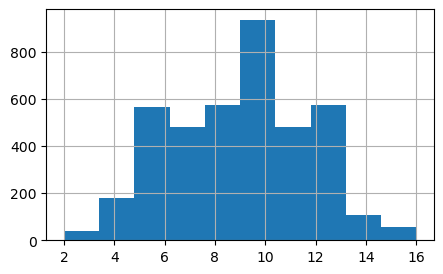

In [7]:
plt.figure(figsize = (5,3))
cust_support_qa_data['len_instruction'].hist()

<Axes: >

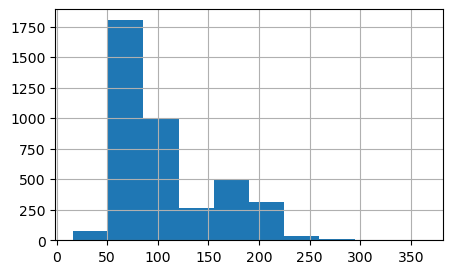

In [8]:
plt.figure(figsize = (5,3))
cust_support_qa_data['len_response'].hist()

# Embed and create a vector store for retrieval

In [11]:
# create embedding
embeddings = embed_model.encode(cust_support_qa_data['instruction'].tolist(), convert_to_numpy=True)

# Create FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
row_num_to_idx = dict(zip(cust_support_qa_data['row_num'], range(len(cust_support_qa_data))))
index.add(embeddings)

In [12]:
# function to query the filtered intent; tracked with row_num field (index all, search some)

def vector_search(query, row_num_filter, top_k=1):
    mask = cust_support_qa_data['row_num'].isin(row_num_filter)
    subset_df = cust_support_qa_data[mask].reset_index(drop=True)
    subset_embeddings = model.encode(subset_df['instruction'].tolist(), convert_to_numpy=True)
    
    temp_index = faiss.IndexFlatL2(dim)
    temp_index.add(subset_embeddings)
    query_embedding = model.encode([query], convert_to_numpy=True)

    D, I = temp_index.search(query_embedding, top_k)
    results = subset_df.iloc[I[0]]
    
    return results[['row_num', 'instruction', 'response']]

In [13]:
vector_search("I want to cancel my order", row_num_filter=[1, 2, 3, 4, 5, 6, 7, 8, 9], top_k = 3)

,row_num,instruction,response
7,8,I have got to cancel purchase {{Order Number}},I'm sensitive to the fact that you're seeking ...
2,3,I need to cancel purchase {{Order Number}},I understood that you need assistance with can...
4,5,can you help me cancel order {{Order Number}}?,"Of course, I'm here to assist you in canceling..."


# Get user query's intent using an LLM

In [14]:
intents = list(cust_support_qa_data['intent'].unique())

intents

['cancel_order', 'delivery_period', 'get_refund', 'track_order']

In [45]:
get_intent_string = """
You are an intelligent assistant that classifies user queries into one of the given intent categories.

Your task is to analyze the user's query and return the most appropriate intent from the list provided.
If the query does not clearly match any of the given intents, return "None".

### Intent Categories:
{intents}

### User Query:
{query}

Strictly output only a JSON file with the following keys:
query_intent
"""

get_intent_prompt_template = ChatPromptTemplate.from_template(get_intent_string)

get_intent_prompt_template

ChatPromptTemplate(input_variables=['intents', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['intents', 'query'], input_types={}, partial_variables={}, template='\nYou are an intelligent assistant that classifies user queries into one of the given intent categories.\n\nYour task is to analyze the user\'s query and return the most appropriate intent from the list provided.\nIf the query does not clearly match any of the given intents, return "None".\n\n### Intent Categories:\n{intents}\n\n### User Query:\n{query}\n\nStrictly output only a JSON file with the following keys:\nquery_intent\n'), additional_kwargs={})])

In [46]:
intent_chain = get_intent_prompt_template | llm

intent_chain

ChatPromptTemplate(input_variables=['intents', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['intents', 'query'], input_types={}, partial_variables={}, template='\nYou are an intelligent assistant that classifies user queries into one of the given intent categories.\n\nYour task is to analyze the user\'s query and return the most appropriate intent from the list provided.\nIf the query does not clearly match any of the given intents, return "None".\n\n### Intent Categories:\n{intents}\n\n### User Query:\n{query}\n\nStrictly output only a JSON file with the following keys:\nquery_intent\n'), additional_kwargs={})])
| ChatOllama(model='llama3.2', temperature=0.0)

In [47]:
#check
query_intent = intent_chain.invoke({
    "intents":intents,
    "query":"I want to cancel my order"
})

query_intent

AIMessage(content='{"query_intent": "cancel_order"}', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-07-25T13:38:35.6359826Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2253968600, 'load_duration': 67844500, 'prompt_eval_count': 127, 'prompt_eval_duration': 1344449400, 'eval_count': 9, 'eval_duration': 841138100, 'model_name': 'llama3.2'}, id='run--b5d91711-e90c-43a6-8dfa-f9d625b4acec-0', usage_metadata={'input_tokens': 127, 'output_tokens': 9, 'total_tokens': 136})

In [48]:
#check
query_intent = intent_chain.invoke({
    "intents":intents,
    "query":"I dont like this product what the hell is it?"
})

query_intent

AIMessage(content='{"query_intent": "None"}', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-07-25T13:38:38.9341992Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2237475100, 'load_duration': 65069900, 'prompt_eval_count': 131, 'prompt_eval_duration': 1363021400, 'eval_count': 8, 'eval_duration': 808552700, 'model_name': 'llama3.2'}, id='run--6b04f8d2-0db1-4736-af23-c1d20badd9b9-0', usage_metadata={'input_tokens': 131, 'output_tokens': 8, 'total_tokens': 139})

In [ ]:
json_parser = JsonOutputParser()

In [49]:
json_parser.parse(query_intent.content)['query_intent']

'None'

# Retrieve previously answered queries and their resolutions

In [200]:
intent_row_nums = cust_support_qa_data[cust_support_qa_data['intent'].isin(['cancel_order'])]['row_num'].tolist()

print(len(intent_row_nums))

998


In [204]:
similar_prev_queries = vector_search("I want to cancel my order", row_num_filter=intent_row_nums, top_k = 3)

similar_prev_queries

,row_num,instruction,response
991,991,cancel order,I've realized that you're seeking assistance i...
311,311,canceling order,"I pick up what you're putting down, your need ..."
479,479,"I bought some product, I want to cancel order ...",I've come to understand that you've made a pur...


# Generate response based on previous query resolutions

In [52]:
response_string = """
You are an intelligent and courteous assistant that helps respond to user queries based on previously resolved similar cases.

Your task is to:
1. Review the previous resolutions listed below.
2. Determine whether any of them clearly and directly address the user's current query.
3. If a relevant resolution exists, use it to craft a polite, helpful response to the user.
4. If none of the previous resolutions are sufficient or relevant, respond with: None

Begin your response with a polite greeting (e.g., "Hello," or "Hi there,") and provide a helpful, natural-sounding reply.

### Previous Resolutions:
{prev_resolutions}

### User Query:
{query}

Respond directly to the user query. If no relevant resolution is found, return: None
"""

response_prompt_template = ChatPromptTemplate.from_template(response_string)

response_prompt_template

ChatPromptTemplate(input_variables=['prev_resolutions', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['prev_resolutions', 'query'], input_types={}, partial_variables={}, template='\nYou are an intelligent and courteous assistant that helps respond to user queries based on previously resolved similar cases.\n\nYour task is to:\n1. Review the previous resolutions listed below.\n2. Determine whether any of them clearly and directly address the user\'s current query.\n3. If a relevant resolution exists, use it to craft a polite, helpful response to the user.\n4. If none of the previous resolutions are sufficient or relevant, respond with: None\n\nBegin your response with a polite greeting (e.g., "Hello," or "Hi there,") and provide a helpful, natural-sounding reply.\n\n### Previous Resolutions:\n{prev_resolutions}\n\n### User Query:\n{query}\n\nRespond directly to the user query. If no relevant resolution is foun

In [53]:
response_chain = response_prompt_template | llm

response_chain

ChatPromptTemplate(input_variables=['prev_resolutions', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['prev_resolutions', 'query'], input_types={}, partial_variables={}, template='\nYou are an intelligent and courteous assistant that helps respond to user queries based on previously resolved similar cases.\n\nYour task is to:\n1. Review the previous resolutions listed below.\n2. Determine whether any of them clearly and directly address the user\'s current query.\n3. If a relevant resolution exists, use it to craft a polite, helpful response to the user.\n4. If none of the previous resolutions are sufficient or relevant, respond with: None\n\nBegin your response with a polite greeting (e.g., "Hello," or "Hi there,") and provide a helpful, natural-sounding reply.\n\n### Previous Resolutions:\n{prev_resolutions}\n\n### User Query:\n{query}\n\nRespond directly to the user query. If no relevant resolution is foun

In [54]:
# check
llm_response = response_chain.invoke({
    "prev_resolutions":similar_prev_queries['response'].unique(),
    "query":"I want to cancel my order"
})

print(llm_response.content)

Hello there,

I'd be happy to help you with canceling your order! Could you please provide me with the order number associated with the purchase you'd like to cancel? With that information, I'll be able to guide you through the process and ensure a seamless cancellation experience.

If you're unable to find the order number or need any further assistance, our dedicated support team is available during {{Customer Support Hours}} at {{Customer Support Phone Number}} or through the Live Chat feature on our website at {{Website URL}}. We value your satisfaction as our customer and are here to help.

Please let me know if there's anything else I can do to assist you.

Best regards,
[Your Assistant]


# Putting it all together

In [68]:
def customer_support_rag(user_query):
    query_intent = intent_chain.invoke({
        "intents":intents,
        "query":user_query
    })
    
    intent = json_parser.parse(query_intent.content)['query_intent']
    
    if intent == 'None':
        print("Please wait. Connecting you to our customer support executive!")
        return
        
    if intent not in intents:
        print("LLM returned invalid user intent!")
        return
    
    intent_row_nums = cust_support_qa_data[cust_support_qa_data['intent'] == intent]['row_num'].tolist()
    similar_prev_queries = vector_search(user_query, row_num_filter=intent_row_nums, top_k = 3)
    
    llm_response = response_chain.invoke({
        "prev_resolutions":similar_prev_queries['response'].unique(),
        "query":user_query
    })
    
    if llm_response.content == "None":
        "Please wait. Connecting you to our customer support executive!"
    
    print(llm_response.content)
    return

In [69]:
customer_support_rag("I want to cancel my order")

Hello there,

I'd be happy to help you with canceling your order! Could you please provide me with the order number associated with the purchase you'd like to cancel? With that information, I'll be able to guide you through the process and ensure a seamless cancellation experience.

If you're unable to find the order number or need any further assistance, our dedicated support team is available during {{Customer Support Hours}} at {{Customer Support Phone Number}} or through the Live Chat feature on our website at {{Website URL}}. We value your satisfaction as our customer and are here to help.

Please let me know if there's anything else I can do to assist you.

Best regards,
[Your Assistant]
